# Planteo

En esta práctica vamos a ver en detalle como funciona SGD. Comenzamos con modelos lineales simples para resolver un problema de ejemplo con el objetivo de entender como funcionan los algoritmos sobre los que después vamos a construir redes complejas. 

El problema puntual es el siguiente:

Tenemos varias mediciones de temperatura en grados celsius y la misma cantidad de mediciones en una unidad desconocida (tomadas por un termómetro que no indica la unidad). Queremos ver si podemos encontrar una función que transforme de esta unidad desconocida a grados celsius.

***

Las medidas tomadas son las siguientes:

Grados celsius: [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]

Equivalente en unidad desconocida: [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]


In [1]:
import torch
import numpy as np

inputs = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4])  # Datos observados
targets = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0])     # Equivalente en celsius

inputs = inputs / 10  # Normalizamos los datos para facilitar entrenamiento.

Definimos un modelo lineal (regresion) como una función, la misma recibe el input (X), los pesos (W) y los bias (b). 

Al ser una regresión lineal, el modelo simplemente computa el producto de cada peso por el input y le suma el bias (No es una red, no tiene activacion!)


In [3]:
def model(X, w, b):
  return w * X + b

In [4]:
# Como usamos el modelo

w_test = torch.ones(())
b_test = torch.zeros(())

prediccion = model(inputs, w_test, b_test)
prediccion

tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800, 4.8400,
        6.0400, 6.8400])

Vamos a usar MSE (Mean Squared Error - Error Cuadrático Medio) como función de costo

In [5]:
def loss_fn(predictions, true_y):
  return torch.mean((predictions - true_y) ** 2)

loss_fn(prediccion, targets)

tensor(80.3643)

# Actualizando

Queremos que el modelo minimize nuestra función de costo, para esto vamos a hacer uso de gradient descent.

GD nos dice que una actualización para nuestros pesos esta dada por:

***

![Image](https://blog.paperspace.com/content/images/2018/05/sgd.png)
***

Donde alfa es un learning rate en el rango (0-1) y es multiplicado por la derivada del costo con respecto a los pesos. En este caso, necesitamos el gradiente con respecto a los pesos W y el bias B.


![Image](https://i.ibb.co/xDW81qF/asd.png)




In [18]:
# Por la regla de la cadena: 
# dloss/dw = (d loss / d targets) * (d targets / d w)
# dloss/db = (d loss / d targets) * (d targets / d b)

def d_loss_d_model(predictions, targets): # predicciones son el resultado de model
    # x^2' = 2 * x
    return 2 * (predictions - targets)

def d_model_dw(X, w, b): # derivada parcial(d_model) del modelo respecto de w
    return X

def d_model_db(X, w, b): # derivada parcial(d_model) del modelo respecto de b
    return 1.0

def grad_fn(X, targets, predictions, w, b):
    d_loss_dw = torch.mean(d_loss_d_model(predictions,targets) * d_model_dw(X, w, b))
    d_loss_db = torch.mean(d_loss_d_model(predictions,targets) * d_model_db(X, w, b))
    return torch.tensor([d_loss_dw, d_loss_db])


In [19]:
grad_fn(inputs, targets, prediccion, w_test, b_test)

tensor([-77.6140, -10.6400])

# Entrenando

Ahora que tenemos los gradientes de los pesos y bias, podemos actualizar los parámetros del modelo para ir mejorando nuestras predicciones


In [38]:
def training_loop(n_epochs, learning_rate, params, targets, X):
    for i in range(n_epochs):
        prediccion = model(X, params[0], params[1])
        params = params - learning_rate * grad_fn(X, targets, prediccion, params[0], params[1])            
    return params

In [39]:
final_params = training_loop(
    n_epochs = 3000, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    targets = targets, 
    X = inputs)

final_params

tensor([  5.3489, -17.1980])

In [42]:
# En Pytorch
def training_loop(n_epochs, learning_rate, params, targets, X):
  for i in range(n_epochs):
    prediccion = model(X,*params)
    loss = loss_fn(prediccion, targets)
    
    if i%200 == 0:
      print("Epoch: ", i, "Loss: ", loss)
    
    params = params - learning_rate * grad_fn(X, targets, prediccion, params[0], params[1])
    
  return params

In [43]:
final_params = training_loop(
    n_epochs = 3000, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    targets = targets, 
    X = inputs)

final_params

Epoch:  0 Loss:  tensor(80.3643)
Epoch:  200 Loss:  tensor(16.5616)
Epoch:  400 Loss:  tensor(9.8343)
Epoch:  600 Loss:  tensor(6.4264)
Epoch:  800 Loss:  tensor(4.7000)
Epoch:  1000 Loss:  tensor(3.8255)
Epoch:  1200 Loss:  tensor(3.3825)
Epoch:  1400 Loss:  tensor(3.1580)
Epoch:  1600 Loss:  tensor(3.0444)
Epoch:  1800 Loss:  tensor(2.9868)
Epoch:  2000 Loss:  tensor(2.9576)
Epoch:  2200 Loss:  tensor(2.9428)
Epoch:  2400 Loss:  tensor(2.9353)
Epoch:  2600 Loss:  tensor(2.9315)
Epoch:  2800 Loss:  tensor(2.9296)


tensor([  5.3489, -17.1980])

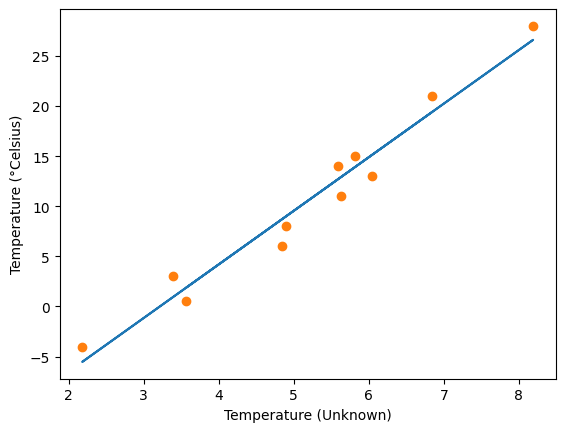

In [24]:
from matplotlib import pyplot as plt

preds = model(inputs, *final_params)  

plt.xlabel("Temperature (Unknown)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(inputs.numpy(), preds.detach().numpy()) 
plt.plot(inputs.numpy(), targets.numpy(), 'o')
plt.show()

Esto sirve para entender que hace Pytorch por detrás con nosotros. Pytorch mantiene un grafo de computo que calcula automáticamente la derivada para hacer el gradiente. 

# Como se resuelve el mismo ejercicio cuando dejamos que Pytorch nos ayude?

Resuelva el mismo problema pero haciendo uso de Pytorch en su totalidad, defina w y b como un torch.parameter (requires_grad=True!!!) y haga uso de loss.backward() para computar los gradientes. 

In [45]:
# En Pytorch
def training_loop(n_epochs, optimizer, params, X, targets):
  for i in range(n_epochs):
    prediccion = model(X,*params)
    loss = loss_fn(prediccion, targets)
    
    if i%200 == 0:
      print("Epoch: ", i, "Loss: ", loss)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
        
  return params
      

In [46]:
import torch.optim as optim

params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate) # <1>

final_params = training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    params = params, # <1> 
    X = inputs,
    targets = targets)

final_params

Epoch:  0 Loss:  tensor(80.3643, grad_fn=<MeanBackward0>)
Epoch:  200 Loss:  tensor(16.5616, grad_fn=<MeanBackward0>)
Epoch:  400 Loss:  tensor(9.8343, grad_fn=<MeanBackward0>)
Epoch:  600 Loss:  tensor(6.4264, grad_fn=<MeanBackward0>)
Epoch:  800 Loss:  tensor(4.7000, grad_fn=<MeanBackward0>)
Epoch:  1000 Loss:  tensor(3.8255, grad_fn=<MeanBackward0>)
Epoch:  1200 Loss:  tensor(3.3825, grad_fn=<MeanBackward0>)
Epoch:  1400 Loss:  tensor(3.1580, grad_fn=<MeanBackward0>)
Epoch:  1600 Loss:  tensor(3.0444, grad_fn=<MeanBackward0>)
Epoch:  1800 Loss:  tensor(2.9868, grad_fn=<MeanBackward0>)
Epoch:  2000 Loss:  tensor(2.9576, grad_fn=<MeanBackward0>)
Epoch:  2200 Loss:  tensor(2.9428, grad_fn=<MeanBackward0>)
Epoch:  2400 Loss:  tensor(2.9353, grad_fn=<MeanBackward0>)
Epoch:  2600 Loss:  tensor(2.9315, grad_fn=<MeanBackward0>)
Epoch:  2800 Loss:  tensor(2.9296, grad_fn=<MeanBackward0>)


tensor([  5.3489, -17.1980], requires_grad=True)

In [ ]:
preds = model(inputs, *final_params)  

plt.xlabel("Temperature (Unknown)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(inputs.numpy(), preds.detach().numpy()) 
plt.plot(inputs.numpy(), targets.numpy(), 'o')
plt.show()